In [1]:
import numpy as np
import pandas as pd
import neurphys.read_pv as rpv
import utilities as util
import detecta as det

from scipy.signal import medfilt
from glob import glob

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#read .csv file of the selected folder and generate a description of the data frame
file = '/Users/ezt309/Documents/2p/electrophys/test recording/test_recording_IC0'
df = rpv.import_folder(file)['voltage recording']
print(df.info())

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 300000 entries, ('sweep001', 0) to ('sweep001', 299999)
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   time       300000 non-null  float64
 1   primary    300000 non-null  float64
 2   secondary  300000 non-null  float64
dtypes: float64(3)
memory usage: 8.3+ MB
None


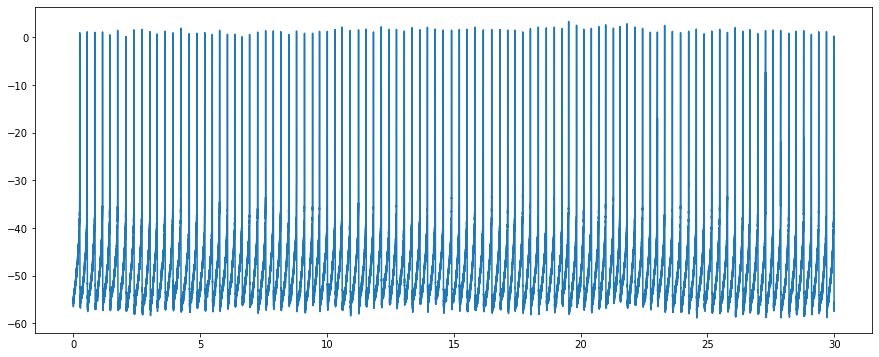

In [7]:
#generate a plot of the recording. 
plt.figure(figsize=(15,6))
plt.plot(df.time, df.primary)
#activate the following line to have the plot of the secondary output overlapped to the primary output
#plt.plot(df.time, df.secondary)
#activate following line to limit the plot to the desired time interval in seconds.
#plt.xlim(10, 20)

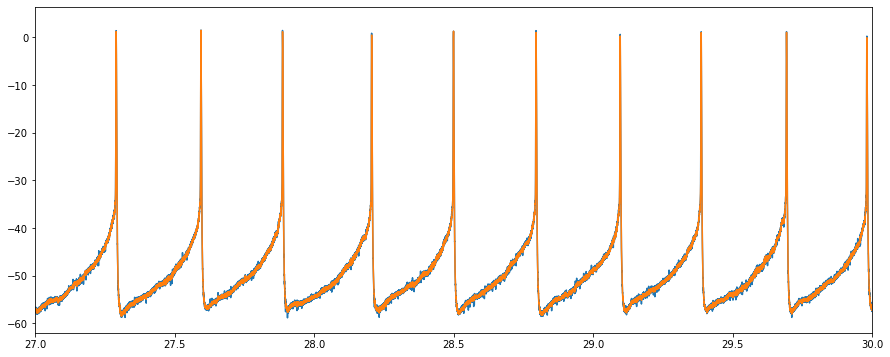

In [15]:
# apply desired smoothing to the primary output. The number indicates the number of points used for the smoothing.
#activate or deactivate the lines corresponding to simple smoothing or Median filter smoothing, according to preference.
primSmooth = util.simple_smoothing(df.primary, 3)
#primMedian = medfilt(df.primary, 3)
#no smoothing with n=1
plt.figure(figsize = (15,6))
plt.plot(df.time, df.primary)
plt.plot(df.time, primSmooth)
#plt.plot(df.time, primMedian)

#acvtivate following line to restrict the plot to a time interval
plt.xlim(27, 30)
#add in the smoothed primary column to the dataframe
df['smoothed'] = primSmooth
#acvtivate following line to save a .pdf figure of the plot
#plt.savefig (file + 'smoothed3.pdf')


In [16]:
# calculating discrete difference on the primary (mV) data with time (ms)
# values start with the second index and run till the end of the file
newarr = (df.smoothed[1:].values - df.smoothed[:-1].values) / (df.time[1:].values - df.time[:-1].values) / 1000
#print(newarr.size)
#print(newarr)
#need to add an initial zero derivative value to make the array parameter lengths match the df data
dvdt = np.insert(newarr, [0], 0.0)
print(dvdt.size)
#print(dvdt)
df['derivative'] = dvdt
print(df.head(5))

300000
                  time    primary  secondary   smoothed  derivative
sweep    index                                                     
sweep001 0      0.0000 -55.633545  -0.610352        NaN    0.000000
         1      0.0001 -55.450439 -11.596680        NaN         NaN
         2      0.0002 -56.518555  -1.831055 -55.867513         NaN
         3      0.0003 -55.725098 -15.258789 -55.898031   -0.305176
         4      0.0004 -55.572510  -4.882812 -55.938721   -0.406901


dV/dt maximum times [5.00000e-01 1.68000e+01 3.48000e+01 ... 2.99614e+04 2.99793e+04
 2.99924e+04]
dV/dt max values    [ 4.67936198  3.15348307  2.95003255 ...  3.35693359 33.46761068
  5.49316406]

dV/dt threshold times  [  249.6   542.    847.7  1148.1  1435.1  1744.6  2068.3  2387.1  2700.7
  3019.2  3298.3  3611.4  3923.2  4232.7  4567.6  4870.6  5179.5  5475.
  5765.1  6072.6  6366.3  6650.1  6946.2  7264.8  7579.3  7881.3  8175.7
  8492.7  8797.   9110.7  9429.8  9703.6 10010.3 10315.6 10589.4 10911.4
 11241.7 11538.2 11830.3 12137.8 12451.8 12737.1 13045.3 13350.6 13661.8
 13956.8 14265.8 14581.  14909.  15214.7 15519.4 15832.  16160.  16491.8
 16822.  17123.1 17403.2 17714.9 18017.5 18329.5 18644.4 18960.2 19269.1
 19525.5 19837.3 20122.5 20419.7 20713.2 20984.7 21290.2 21553.5 21828.9
 22140.9 22440.1 22746.5 23023.6 23309.9 23615.3 23937.9 24257.4 24558.3
 24866.8 25168.5 25480.8 25785.5 26091.8 26389.4 26668.  26983.1 27288.
 27591.9 27884.6 28203.8 28497.  28793.  29094.3 2

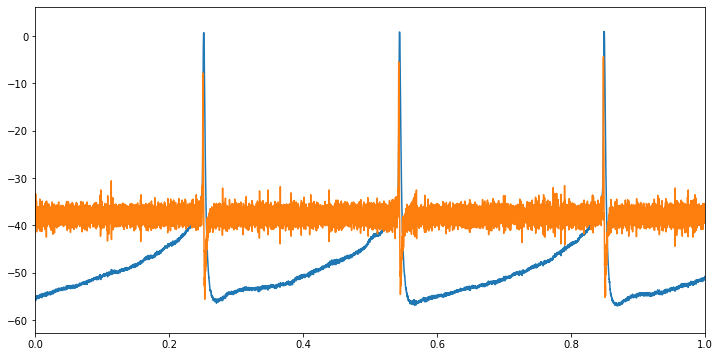

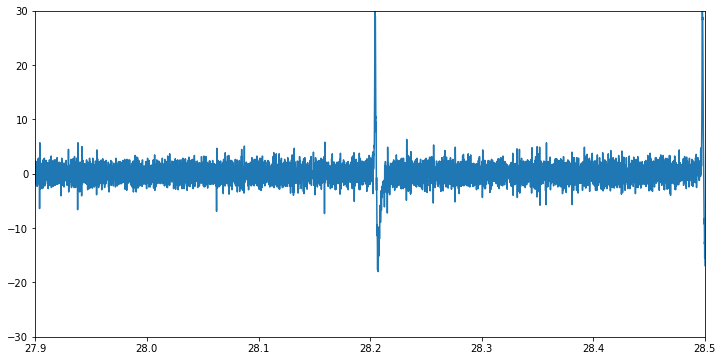

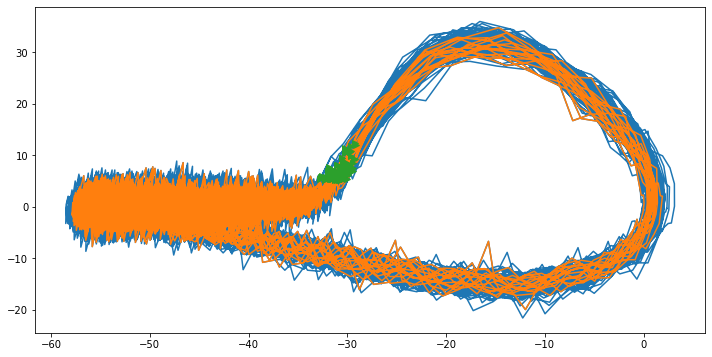

In [28]:
#plotting cell
#shifting the minimum voltage to overlay the derivative and the AP voltage trace for visualization purpose
shftarr = dvdt - 38
#plotting out the derivative and voltage with time (use xlim values to restrict time window)
plt.figure(figsize=(12,6))
plt.plot(df.time, df.smoothed)
plt.plot(df.time, shftarr)
plt.xlim(0, 1)

#plotting out the discrete derivative with time (use xlim values to restrict time window)
plt.figure(figsize=(12,6))
plt.plot(df.time, df.derivative)
plt.xlim(27.9, 28.5)
plt.ylim(-30,30)

#plotting out the phase plot of derivative with voltage (selected time window trace plotted)
#easy to see the AP voltage threshold and derivative threshold value

#acvtivate following lines to generate a plot for a desired interval of the recording. 
#APmaskA = (df.time > 0) & (df.time < 5)
#APsubsetA = df[APmaskA].droplevel(0)

plt.figure(figsize=(12,6))
plt.plot(df.smoothed, df.derivative)
#activate follwing line to have the plot for the specific subset plotted over the full recording in a different color
#plt.plot(APsubsetA.smoothed, APsubsetA.derivative)


dVdtPeakList = det.detect_peaks(df.derivative, mph = -20, mpd=100)
#plt.plot(df.smoothed.iloc[dVdtPeakList], df.derivative.iloc[dVdtPeakList], 'o')
print('dV/dt maximum times', dVdtPeakList/10)
Slope = df.derivative.iloc[dVdtPeakList].droplevel(0).values
print('dV/dt max values   ', Slope)
print()

dVdtSet = det.detect_onset(df.derivative, threshold = 5, n_above = 4, threshold2 = 10)
#print(dVdtSet)
RampList = dVdtSet[:,0]
print('dV/dt threshold times ', RampList/10)
Thresh = df.derivative.iloc[RampList].droplevel(0).values
ThreshmV = df.smoothed.iloc[RampList].droplevel(0).values
print('dV/dt threshold values', Thresh)
print('ThreshmV', ThreshmV)
print()

#activate followin line to have > symbols indicate the AP treshold
#plt.plot(df.smoothed.iloc[RampList], df.derivative.iloc[RampList], '>')

#select either all phase plots or the phase plot only for the specific time, or both; the second option is shown in orange
#plt.savefig(file + 'testplots.pdf')


99 100
APs           [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96
 97 98 99]
AP peak times [  251.4   543.8   849.2  1149.6  1436.7  1746.4  2070.   2388.9  2702.3
  3020.8  3299.9  3613.   3924.9  4234.6  4569.2  4872.3  5181.4  5476.9
  5766.8  6074.6  6367.8  6651.9  6947.9  7266.6  7580.9  7882.9  8177.4
  8494.4  8798.7  9112.4  9431.6  9705.4 10011.9 10317.3 10591.1 10913.1
 11243.4 11540.  11831.9 12139.5 12453.6 12738.8 13047.2 13352.3 13663.4
 13958.6 14267.4 14582.6 14910.7 15216.5 15521.3 15833.6 16161.7 16493.6
 16823.5 17124.8 17405.  17716.8 18019.2 18331.1 18646.1 18961.9 19270.9
 19527.3 19838.9 20124.2 20421.4 20715.  20986.3 21291.8 21555.2 21830.7
 22142.5 22441.9 22748.1 23025.3 23311.6 23616.9 23939.6 24259.  24560.
 24868

(0.0, 30.0)

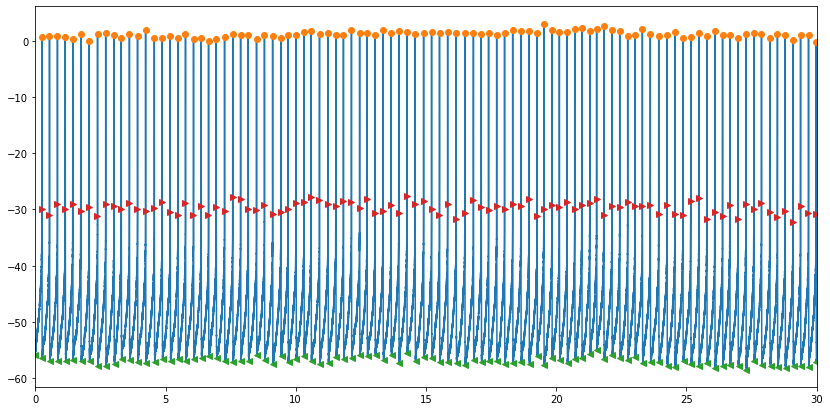

In [36]:
#Identify peaks and calculate parameters for each peak
mask = (df.time > 0) & (df.time < 30)
subset = df[mask]
plt.figure(figsize=(14,7))
plt.plot(subset.time, subset.smoothed)

APPeakList = det.detect_peaks(subset.smoothed, mph= -20, mpd=1000)
APISI = np.insert((APPeakList[1:] - APPeakList[:-1]), [0], 0.0)
APmV = df.smoothed.iloc[APPeakList].droplevel(0).values
APMinList = det.detect_peaks(subset.smoothed, mph= -55, mpd=1000, valley=True, edge='rising', threshold=0)
APMinmV = df.smoothed.iloc[APMinList].droplevel(0).values

print(APPeakList.size, APMinList.size)

APList = np.arange(1, (len(APPeakList)+1), 1)
print('APs          ', APList)
print('AP peak times', APPeakList/10)
print('AP peak (mV) ', APmV)
print('AP interval  ', APISI/10)
print()
print('AP min times', APMinList/10)
print('AP min (mV) ', APMinmV)

#Activate the lines below that correspond to values that should appear in the plot
plt.plot(subset.time.iloc[APPeakList], subset.smoothed.iloc[APPeakList], 'o')
plt.plot(subset.time.iloc[APMinList], subset.smoothed.iloc[APMinList], '<')
plt.plot(subset.time.iloc[RampList], subset.smoothed.iloc[RampList], '>')
plt.xlim(0, 30)
#plt.savefig(file + '_trace_threshold5_&peaks_smoothed3.pdf')


In [43]:
#creates a table with all the selected values. 
APdf = pd.DataFrame(APList, columns=['Event'])
#Activate any of the following lines that should be listed in the table.
APdf['threshtime'] = (RampList+ 1)/10
APdf['threshslope'] = Thresh
APdf['threshmV'] = ThreshmV
APdf['APpeaktime'] = (APPeakList + 1)/10
APdf['APpeakmV'] = APmV
APdf['APISI'] = APISI/10

#Note that the script can detect the upstroke of the first AP as a minimum, upon inspection of the plot select if the first detected minimum is correct or not.
#when 1st minimum should be included:
#APdf['APMintime'] = (APMinList [0:] + 1)/10
#APdf['APMinmV'] = APMinmV [0:]

#when 1st minimum should be excluded (no peak)
APdf['APMintime'] = (APMinList[1:] + 1)/10
APdf['APMinmV'] = APMinmV[1:]

APdf.to_csv(file + 'T5_smoothed3.csv', index= False)
APdf

,Event,threshtime,threshslope,threshmV,APpeaktime,APpeakmV,APISI,APMintime,APMinmV
0,1,249.7,5.391439,-30.436198,251.5,0.579834,0.0,270.5,-56.335449
1,2,542.1,5.696615,-31.555176,543.9,0.823975,292.4,566.8,-56.833903
2,3,847.8,8.341471,-30.202230,849.3,0.610352,305.4,869.2,-56.844076
3,4,1148.2,6.917318,-31.148275,1149.7,0.356038,300.4,1167.6,-56.803385
4,5,1435.2,10.477702,-30.263265,1436.8,0.284831,287.1,1452.7,-56.793213
...,...,...,...,...,...,...,...,...,...
94,95,28793.1,6.917318,-31.412760,28794.7,0.834147,295.7,28816.1,-57.983398
95,96,29094.4,5.289714,-32.725016,29096.3,-0.010173,301.6,29119.1,-57.759603
96,97,29385.0,7.120768,-30.670166,29386.6,0.691732,290.3,29406.9,-57.617188
97,98,29690.6,6.103516,-31.321208,29692.6,0.935872,306.0,29711.2,-57.779948


In [44]:
#statistical analysis for parameters above
print('    THRESHOLD')
print(APdf['threshslope'].describe())
print(APdf['threshmV'].describe())
print('    PEAKS')
print(APdf['APpeakmV'].describe())
print(APdf['APMinmV'].describe())
print('    INTERVALS')
print(APdf['APISI'][1:].describe())
print()


    THRESHOLD
count    99.000000
mean      7.125906
std       1.700909
min       5.086263
25%       5.849202
50%       6.815592
75%       7.934570
max      12.308757
Name: threshslope, dtype: float64
count    99.000000
mean    -30.670474
std       0.813829
min     -32.725016
25%     -31.290690
50%     -30.537923
75%     -30.054728
max     -29.174805
Name: threshmV, dtype: float64
    PEAKS
count    99.000000
mean      1.058867
std       0.558359
min      -0.111898
25%       0.717163
50%       0.996908
75%       1.403809
max       3.102620
Name: APpeakmV, dtype: float64
count    99.000000
mean    -56.825477
std       0.661615
min     -58.176676
25%     -57.266235
50%     -56.833903
75%     -56.401571
max     -54.951986
Name: APMinmV, dtype: float64
    INTERVALS
count     98.000000
mean     303.358163
std       15.177737
min      256.400000
25%      294.675000
50%      305.400000
75%      312.900000
max      334.600000
Name: APISI, dtype: float64

